RAIN - Real & Artificial Intelligence for Neuroscience

## Create models
- This notebook will create and train Artificial Neural Networks to identify exploration using rodent and target position along with manually labeled data.

#### Requirements:

- A set of position files
- Labeled data for those position files (to train the model)

or

- Access to the example file **colabels.csv**, where we can find:
    - Position and labels for representative exploration events
    - Manual labels from 5 viewers (so far)

---
#### Load the necessary modules

In [2]:
import os
import rainstorm.modeling as rst

---
#### 1. State your models project path
`base` : The path to the downloaded repository.

`models_folder` : The path to the folder containing the files you'll use to create the models.

In [ ]:
base = r'c:\Users\dhers\Desktop\Rainstorm'
models_folder = os.path.join(base, r'docs\models')

---
#### 2.  Create the params.yaml file

The modeling.yaml file is a configuration file that contains all the parameters needed to create and train the models. It will be located in the models folder.

It contains the following parameters:

`path` : Path to the models folder

`colabels` : The colabels file is used to store and organize positions and labels for model training
- colabels_path: Path to the colabels folder
- labelers: List of labelers on the colabels file (as found in the columns)
- target: Name of the target on the colabels file

`focus_distance`: Window of frames to consider around an exploration event

`bodyparts`: List of bodyparts used to train the model

`split`: Parameters for splitting the data into training, validation, and testing sets
- validation: Percentage of the data to use for validation
- test: Percentage of the data to use for testing

`LSTM_shape` : Defines the shape of the LSTM model
- past : Number of past frames to include
- future : Number of future frames to include
- broad : Broaden the window by skipping some frames as we stray further from the present

In [4]:
modeling = rst.create_modeling(models_folder)

modeling.yaml already exists in 'c:\Users\dhers\Desktop\Rainstorm\docs\models'.
Skipping creation.


---
#### 2. Before training a model, we need to prepare our training data
- First, we load the dataset from the colabels file and create one 'labels' column out of all the labelers.
- Next (optional, but recommended) we can erase the rows of the dataset that are too far away from exploration events.
- Finally, we split the dataset into training, testing and validation subsets.

In [ ]:
# Prepare the data
dataset = rst.prepare_data(modeling) # This method of importing data should be improved

# Focus on the rows near exploratory behaviour
dataset = rst.focus(modeling, dataset)

# Split the data
model_dict = rst.split_tr_ts_val(modeling, dataset)

# Save the split
rst.save_split(models_folder, model_dict)

Starting with 167012 rows
Reduced to 34044 rows. Number of exploration rows: 10471
Training set size: 23165 samples
Validation set size: 5418 samples
Testing set size: 5461 samples
Total samples: 34044
Saved data to split_2025-03-11_7w.h5


---
If you later want to load a previous split, run:

```python
saved_split = os.path.join(models_folder, 'splits/split_example_7w.h5') # Select the split you want to rescue
model_dict = rst.load_split(saved_split)
```

---
We can see on the testing data that the exploratory events happen when the nose gets close to the object

In [6]:
rst.plot_example_data(model_dict['X_ts'], model_dict['y_ts'])

---
#### 3. With our training data ready, we can use TensorFlow to design our very first model
- It will look at the positions of one frame at a time, and try to decide if the mouse is exploring.
- If the decision is correct the architecture will be reinforced, else it will be corrected according to the learning rate.
- We will train it for some epochs (cycles through the whole dataset) and plot how the accuracy and loss evolve.
- Also, we will be validating the training using the validation split, which contains frames that were not used for training.

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
import datetime
start_time = datetime.datetime.now()

# Build a simple neural network
model_simple = tf.keras.Sequential([
    
    # Input layer
    Input(shape=(model_dict['X_tr'].shape[1],)), 

    # Hidden layers
    Dense(32, activation='relu'),
    Dense(24, activation='relu'),
    Dense(16, activation='relu'),
    Dense(12, activation='relu'),
    Dense(8, activation='relu'),
    
    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile the model
model_simple.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                   loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
model_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                416       
                                                                 
 dense_1 (Dense)             (None, 24)                792       
                                                                 
 dense_2 (Dense)             (None, 16)                400       
                                                                 
 dense_3 (Dense)             (None, 12)                204       
                                                                 
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,925
Trainable params: 1,925
Non-trainabl

In [9]:
# Train the model
history_simple = model_simple.fit(model_dict['X_tr'], model_dict['y_tr'],
                                  epochs=10, # An epoch is a complete pass through the entire training dataset.
                                  batch_size=64, # The batch size is the number of training samples the model processes before updating its weights.
                                  validation_data=(model_dict['X_val'], model_dict['y_val']))

Epoch 1/10
362/362 [==============================] - 1s 2ms/step - loss: 0.4895 - accuracy: 0.6240 - val_loss: 0.4003 - val_accuracy: 0.6633
Epoch 2/10
362/362 [==============================] - 0s 1ms/step - loss: 0.4024 - accuracy: 0.6481 - val_loss: 0.3208 - val_accuracy: 0.7102
Epoch 3/10
362/362 [==============================] - 0s 1ms/step - loss: 0.3351 - accuracy: 0.7079 - val_loss: 0.2574 - val_accuracy: 0.7903
Epoch 4/10
362/362 [==============================] - 0s 1ms/step - loss: 0.2900 - accuracy: 0.7422 - val_loss: 0.2220 - val_accuracy: 0.8016
Epoch 5/10
362/362 [==============================] - 0s 1ms/step - loss: 0.2652 - accuracy: 0.7524 - val_loss: 0.1999 - val_accuracy: 0.8016
Epoch 6/10
362/362 [==============================] - 0s 1ms/step - loss: 0.2515 - accuracy: 0.7570 - val_loss: 0.1911 - val_accuracy: 0.8016
Epoch 7/10
362/362 [==============================] - 0s 1ms/step - loss: 0.2439 - accuracy: 0.7583 - val_loss: 0.1859 - val_accuracy: 0.8044
Epoch 

In [10]:
# Plot the training and validation loss
rst.plot_history(history_simple, "Simple")

In [11]:
y_pred_simple = model_simple.predict(model_dict['X_ts'])

# Calculate accuracy and precision of the model
accuracy_simple, precision_simple, recall_simple, f1_simple, mse_simple, mae_simple, r2_simple = rst.evaluate(y_pred_simple, model_dict['y_ts'], show_report = True)
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f}, MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")

171/171 [==============================] - 0s 638us/step
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      4058
           1       0.78      0.88      0.82      1403

    accuracy                           0.90      5461
   macro avg       0.87      0.89      0.88      5461
weighted avg       0.91      0.90      0.91      5461

Accuracy = 0.9035, Precision = 0.9093, Recall = 0.9035, F1 Score = 0.9053, MSE = 0.0529, MAE = 0.1253, R-squared = 0.7082 -> simple


In [12]:
# Save the model
model_simple.save(os.path.join(models_folder, f'm_simple/simple_{start_time.date()}.keras'))

---
#### 4. Now that we have a simple model trained, we can start building more complex models with the help of some functions

To make our artificial networks as real as possible, we can let them see a sequence of frames to decide if the mouse is exploring.
- Our build_LSTM_model function will use Bidirectional LSTM layers that allow the model to take into account the sequence of frames.
- With `units` we can say how many and how big our hidden layers will be.
- We also implement an early stopping and learning rate scheduler mechanisms that will prevent the model from overfitting.


In [11]:
# Set the number of neurons in each layer
input_shape = (model_dict['X_tr_wide'].shape[1], model_dict['X_tr_wide'].shape[2])
units = [32, 24, 16, 8]

batch_size = 64 # Set the batch size
lr = 0.0001 # Set the initial learning rate
epochs = 60 # Set the training epochs

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, mode='min', verbose=1)

# Define a learning rate schedule function
def lr_schedule(epoch):
    warmup_epochs = 6  # Number of warm-up epochs
    initial_lr = 6e-5  # Starting learning rate
    peak_lr = 2e-4     # Peak learning rate
    decay_factor = 0.9 # Decay factor

    if epoch < warmup_epochs:
        # Exponential warm-up: increase learning rate exponentially
        return initial_lr * (peak_lr / initial_lr) ** (epoch / warmup_epochs)
    else:
        # Start decay after warm-up
        return peak_lr * (decay_factor ** (epoch - warmup_epochs))

# Define the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [13]:
# Build model
model_wide = rst.build_LSTM_model(input_shape, units)

# Compile model
model_wide.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                   loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
model_wide.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 12)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 7, 64)            11520     
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 7, 64)            256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 7, 64)             0         
                                                                 
 lambda (Lambda)             (None, 5, 64)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 5, 48)            17088 

In [15]:
# Train the model
history_wide = model_wide.fit(model_dict['X_tr_wide'], model_dict['y_tr'],
                              epochs = epochs,
                              batch_size = batch_size,
                              validation_data=(model_dict['X_val_wide'], model_dict['y_val']),
                              verbose = 2,
                              callbacks=[early_stopping, lr_scheduler])

Epoch 1/60
416/416 - 12s - loss: 0.7188 - accuracy: 0.5613 - val_loss: 0.4615 - val_accuracy: 0.6698 - lr: 6.0000e-05 - 12s/epoch - 30ms/step
Epoch 2/60
416/416 - 4s - loss: 0.5473 - accuracy: 0.6704 - val_loss: 0.4446 - val_accuracy: 0.6920 - lr: 7.3333e-05 - 4s/epoch - 10ms/step
Epoch 3/60
416/416 - 4s - loss: 0.4551 - accuracy: 0.7282 - val_loss: 0.4117 - val_accuracy: 0.7123 - lr: 8.9628e-05 - 4s/epoch - 9ms/step
Epoch 4/60
416/416 - 4s - loss: 0.3919 - accuracy: 0.7608 - val_loss: 0.4030 - val_accuracy: 0.7209 - lr: 1.0954e-04 - 4s/epoch - 10ms/step
Epoch 5/60
416/416 - 4s - loss: 0.3391 - accuracy: 0.7825 - val_loss: 0.3872 - val_accuracy: 0.7232 - lr: 1.3389e-04 - 4s/epoch - 9ms/step
Epoch 6/60
416/416 - 4s - loss: 0.3013 - accuracy: 0.7917 - val_loss: 0.3706 - val_accuracy: 0.7236 - lr: 1.6364e-04 - 4s/epoch - 9ms/step
Epoch 7/60
416/416 - 4s - loss: 0.2709 - accuracy: 0.8001 - val_loss: 0.3529 - val_accuracy: 0.7204 - lr: 2.0000e-04 - 4s/epoch - 10ms/step
Epoch 8/60
416/416 - 

In [16]:
# Plot the training and validation loss
rst.plot_history(history_wide, "wide")

In [17]:
y_pred_wide = model_wide.predict(model_dict['X_ts_wide'])

# Calculate accuracy and precision of the model
accuracy_wide, precision_wide, recall_wide, f1_wide, mse_wide, mae_wide, r2_wide = rst.evaluate(y_pred_wide, model_dict['y_ts'], show_report=True)
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f}, MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")

190/190 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      4581
           1       0.81      0.85      0.83      1481

    accuracy                           0.91      6062
   macro avg       0.88      0.89      0.89      6062
weighted avg       0.92      0.91      0.91      6062

Accuracy = 0.9141, Precision = 0.9155, Recall = 0.9141, F1 Score = 0.9147, MSE = 0.0524, MAE = 0.0930, R-squared = 0.7015 -> wide


In [18]:
# Save the model
model_wide.save(os.path.join(models_folder, f'm_wide/wide_{start_time.date()}_{model_dict["X_ts_wide"].shape[1]}w.keras'))

---
#### 5. Another method for classification using machine learning is creating a Random Forest model:

- Random Forest works by creating lots of decision trees during training.
- The output of the Random Forest in our case will be 1 or 0 (exploration or not) according to the decision of most trees.
- It is a very simple model to train.

In [19]:
from sklearn.ensemble import RandomForestClassifier
import joblib

In [20]:
# We train a RF model with the same data, but first we make it discrete
y_tr = (model_dict['y_tr'] > 0.5).astype(int)

# Create the Random Forest model
RF_model = RandomForestClassifier(n_estimators = 24, max_depth = 12)

# Train the MultiOutputClassifier
RF_model.fit(model_dict['X_tr'], y_tr)

RandomForestClassifier(max_depth=12, n_estimators=24)

In [21]:
y_pred_RF = RF_model.predict(model_dict['X_ts'])

# Calculate accuracy and precision of the model
accuracy_RF, precision_RF, recall_RF, f1_RF, mse_RF, mae_RF, r2_RF = rst.evaluate(y_pred_RF, model_dict['y_ts'], show_report=True)
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f}, MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4581
           1       0.85      0.84      0.84      1481

    accuracy                           0.92      6062
   macro avg       0.90      0.89      0.90      6062
weighted avg       0.92      0.92      0.92      6062

Accuracy = 0.9236, Precision = 0.9232, Recall = 0.9236, F1 Score = 0.9234, MSE = 0.0671, MAE = 0.0834, R-squared = 0.6183 -> RF


In [22]:
# Save the model
joblib.dump(RF_model, os.path.join(models_folder, f'm_RF/RF_{start_time.date()}.pkl'))

['c:\\Users\\dhers\\Desktop\\Rainstorm\\docs\\models\\m_RF/RF_2025-03-10.pkl']

---
#### 6. Finally, we can compare all the models we've trained

- Since we trained using the training dataset, and validated using the validation dataset... we test each model using the testing dataset.
- To compare each model with the performance of a human labeler, we shall meet again on the following notebook.

In [23]:
# Print the model results
print("Evaluate model vs testing data")

print("VS binary average")
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")

print("VS continuous average")
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")

Evaluate model vs testing data
VS binary average
Accuracy = 0.9015, Precision = 0.8993, Recall = 0.9015, F1 Score = 0.8997 -> simple
Accuracy = 0.9141, Precision = 0.9155, Recall = 0.9141, F1 Score = 0.9147 -> wide
Accuracy = 0.9236, Precision = 0.9232, Recall = 0.9236, F1 Score = 0.9234 -> RF
VS continuous average
MSE = 0.0556, MAE = 0.1193, R-squared = 0.6833 -> simple
MSE = 0.0524, MAE = 0.0930, R-squared = 0.7015 -> wide
MSE = 0.0671, MAE = 0.0834, R-squared = 0.6183 -> RF


---
---
#### Our trained models are stored safely in our repository, with today's date.
We can:
- Continue on this notebook and evaluate the trained models.
- Skip the evaluation and go use the models on our data in `5-Automatic_analysis`.
---


## Evaluate models

I see you've decided to continue on this notebook! You wont regret it.

One may think that the evaluation we did on the testing set is enough, and in many cases it is. However, for our purpose of finding a model that resembles the labeling of an expert, It's better to compare the performance of the model against all the manually labeled data we have.

We need to specify the following parameters:

`labelers` : Names of the people that labeled the data (they should be the same as the columns in the `colabels` file).

`past` & `future` : If you use a LSTM model, you can set the window size by saying how many frames into the past and how many into the future you want to see.

`broad` : Once you have your window size, we can broaden the window by skipping some frames as we stray further from the present.

In [35]:
labelers = ['Labeler_A', 'Labeler_B', 'Labeler_C', 'Labeler_D', 'Labeler_E']
past, future = 3, 3 # Set the window size for the LSTM model
broad = 1.7 # Set how broad the window is (skipping frames)

In [37]:
import pandas as pd

# Open the colabels file
colabels_df = pd.read_csv(colabels_path)
position = colabels_df.filter(regex='_x|_y').filter(regex='^(?!.*tail)').copy() # Extract positions, excluding tail-related columns
manual_labels = pd.concat([colabels_df.filter(regex=name).copy() for name in labelers], axis=1) # Extract individual labelers' columns
geometric = colabels_df.filter(regex='Geometric').copy() # Extract geometric labels

use_model = str(start_time.date()) # if you want to use previously trained models, change this variable to 'example' or to a specific date (e.g. '2024-02-16')
print(f'Using models from: {use_model}')

Using models from: 2025-03-10


---
#### 7. Calculate a good reference labeler
Since we want to compare the models and the labelers, we need to create a reference labeler.

This reference could be the mean of all the labelers, but then the labelers would have an unfair advantage.

To avoid this, we choose to simultaneously create a chimera labeler and a leave-one-out-mean:
- The chimera is created by randomly selecting a labeler on each row of the data.
- The leave-one-out-mean is created by averaging the remaining labelers.

This way, we can compare the chimera to the leave-one-out-mean knowing that they are independent.

In [27]:
# Create the chimera and the leave-one-out mean
chimera, loo_mean = rst.create_chimera_and_loo_mean(manual_labels, seed=42) 
loo_mean = rst.smooth_columns(loo_mean, columns=['loo_mean'])

# We can still calculate the mean of all the labelers and see how it compares to the leave-one-out mean
full_mean = pd.DataFrame(manual_labels.sum(axis=1)/manual_labels.shape[1], columns=["full_mean"])

---
#### 8. Load the models & use them to label exploration on all the available data

In [28]:
# Load the saved models
from keras.models import load_model
model_simple = load_model(os.path.join(models_folder, f'm_simple/simple_{use_model}.keras'))
model_wide = load_model(os.path.join(models_folder, f'm_wide/wide_{use_model}_{past+future+1}w.keras'))

from joblib import load
RF_model = load(os.path.join(models_folder, f'm_RF/RF_{use_model}.pkl'))

In [29]:
X_all = position.copy()

all_RF = rst.use_model(X_all, RF_model, objects=['tgt'])
all_wide = rst.use_model(X_all, model_wide, objects=['tgt'], reshaping = True, past=past, future=future, broad=broad)
all_simple = rst.use_model(X_all, model_simple, objects=['tgt'])

c:\Users\dhers\miniconda3\envs\rainstorm\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



5220/5220 [==============================] - 3s 586us/step


In [30]:
# We can create a dictionary containing all labelers to compare them with the loo mean
all_labelers = {'simple': all_simple, 'wide': all_wide, 'RF': all_RF,
                'chimera': chimera, 'mean': loo_mean,} # 'geometric': geometric, 'full_mean': full_mean

# add the manual labels to the dictionary
for name in labelers:
    all_labelers[name] = colabels_df.filter(regex=name).copy()

print(all_labelers.keys())  # Check the keys to confirm the additions

dict_keys(['simple', 'wide', 'RF', 'chimera', 'mean', 'Labeler_A', 'Labeler_B', 'Labeler_C', 'Labeler_D', 'Labeler_E'])


---
#### 9. With all the labels organized, we can evaulate the performance of each

In [31]:
for name, pred in all_labelers.items():
    accuracy, precision, recall, f1, mse, mae, r2 = rst.evaluate(pred, loo_mean)
    print(f"Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, MSE = {mse:.4f}, MAE = {mae:.4f}, R-squared = {r2:.4f} -> {name}")

Accuracy = 0.9781, Precision = 0.9777, Recall = 0.9781, F1 Score = 0.9779, MSE = 0.0118, MAE = 0.0278, R-squared = 0.7778 -> simple
Accuracy = 0.9839, Precision = 0.9843, Recall = 0.9839, F1 Score = 0.9841, MSE = 0.0083, MAE = 0.0210, R-squared = 0.8423 -> wide
Accuracy = 0.9853, Precision = 0.9855, Recall = 0.9853, F1 Score = 0.9854, MSE = 0.0122, MAE = 0.0183, R-squared = 0.7691 -> RF
Accuracy = 0.9781, Precision = 0.9795, Recall = 0.9781, F1 Score = 0.9786, MSE = 0.0177, MAE = 0.0239, R-squared = 0.6645 -> chimera
Accuracy = 1.0000, Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000, MSE = 0.0000, MAE = 0.0000, R-squared = 1.0000 -> mean
Accuracy = 0.9800, Precision = 0.9846, Recall = 0.9800, F1 Score = 0.9812, MSE = 0.0126, MAE = 0.0188, R-squared = 0.7613 -> Labeler_A
Accuracy = 0.9801, Precision = 0.9802, Recall = 0.9801, F1 Score = 0.9783, MSE = 0.0185, MAE = 0.0246, R-squared = 0.6506 -> Labeler_B
Accuracy = 0.9680, Precision = 0.9786, Recall = 0.9680, F1 Score = 0.9710, MS

We can visualize the similarity between labelers using a cosine similarity plot

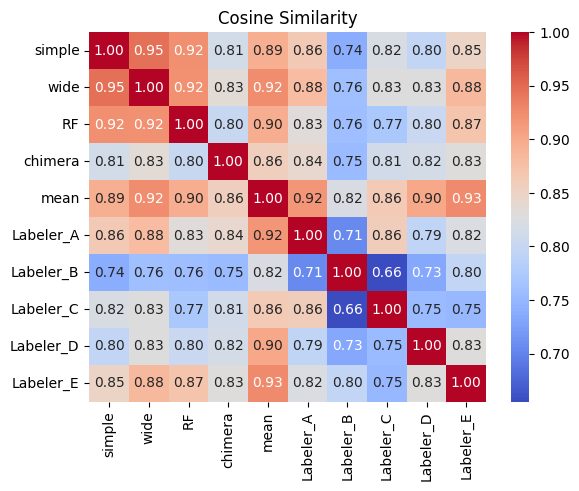

In [32]:
cosine_sim = rst.calculate_cosine_sim(all_labelers)

And finally, run a PCA (Principal Components Analysis) to see how much each labeler resembles eachother and the mean

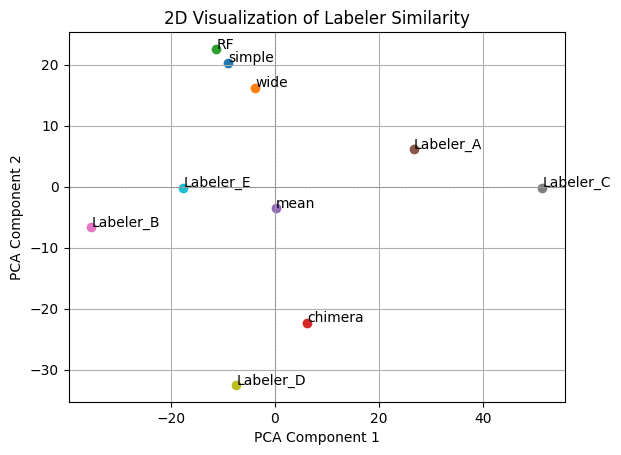

In [33]:
rst.plot_PCA(all_labelers)

Also, we can see both the models and the labelers performance on an example video

In [34]:
example_path = os.path.join(base, r'docs\examples\colabeled_video')

labelers_example = {
    "labeler_A": "Example_Marian.csv",
    "labeler_B": "Example_Agus.csv",
    "labeler_C": "Example_Santi.csv",
    "labeler_D": "Example_Guille.csv",
    "labeler_E": "Example_Myself.csv"
}

models = {
    "RF": (RF_model, {}),
    "Wide": (model_wide, {"reshaping": True}),
    "Simple": (model_simple, {}),
}

rst.plot_performance_on_video(example_path, models, labelers_example, plot_obj="obj_2")

c:\Users\dhers\miniconda3\envs\rainstorm\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



469/469 [==============================] - 0s 672us/step


---
---
#### Once we get to this point, we should have selected our favorite model.
We can move on to the next notebook, `5-Automatic_analysis`, and use the chosen model to label our position files.

---
RAINSTORM - Created on Dec 12, 2023 - @author: Santiago D'hers